In [8]:
import re
from datetime import datetime
import os

# Define the directory path where the files are stored
directory_path = 'Z:/Lab Data/Qudit_Ramsey_raw_data/Raw_data_PD/'

def parse_filename(filename):
    pattern = (
        r'Ramsey_qudit_WaitTime(\d+)us_d=(\d+)_Cal_(True|False)_U1only_(True|False)_(\d+)_'
        r'(\d{8})_(\d{4})\.txt'
    )
    match = re.search(pattern, filename)
    if match:
        wait_time = int(match.group(1))
        d_value = int(match.group(2))
        cal_flag = match.group(3) == "True"
        u1_only = match.group(4) == "True"
        extra_param = int(match.group(5))
        date_str = match.group(6) + match.group(7)  # "YYYYMMDDHHMM"
        date_time = datetime.strptime(date_str, '%Y%m%d%H%M')

        return (
            wait_time,
            d_value,
            cal_flag,
            u1_only,
            extra_param,
            date_time
        )
    else:
        return (None, None, None, None, None, None)


def extract_raw_data_filenames(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    raw_data_filenames_line = lines[-1].strip()
    raw_data_filenames = [
        name.strip().strip("'\"") for name in raw_data_filenames_line.strip('[]').split(',')
    ]
    return raw_data_filenames


def search_files_by_date_and_transitions(directory, target_dates):
    wait_time_list = []
    raw_file_paths_list = []
    final_params = (None, None, None, None, None)

    for filename in os.listdir(directory):
        if filename.startswith('Ramsey_qudit_WaitTime'):
            (wait_time, d_value, cal_flag, u1_only, extra_param, date_time) = parse_filename(filename)
            if date_time is None:
                continue
            
            if date_time.date() in target_dates:
                final_params = (wait_time, d_value, cal_flag, u1_only, extra_param)
                file_path = os.path.join(directory, filename)
                raw_data_filenames = extract_raw_data_filenames(file_path)
                Z_drive_raw_data = 'Z:\\Lab Data\\Qudit_Ramsey_raw_data\\Raw_data\\'
                raw_data_filepaths = [os.path.join(Z_drive_raw_data, raw_filename) for raw_filename in raw_data_filenames]
                wait_time_list.append(wait_time)
                raw_file_paths_list.append(raw_data_filepaths)

    return wait_time_list, raw_file_paths_list, final_params


if __name__ == "__main__":
    date_strings = [
        "20250312",
    ]
    target_dates = set(datetime.strptime(ds, '%Y%m%d').date() for ds in date_strings)

    wait_time_list, raw_file_paths_list, final_params = search_files_by_date_and_transitions(directory_path, target_dates)
    wait_time, d_value, cal_flag, u1_only, extra_param = final_params
    
    print(f"Parameters: WaitTime={wait_time}us, d={d_value}, Cal={cal_flag}, U1only={u1_only}, extra={extra_param}")
    print("\nWait times and corresponding raw data file paths:")
    for wt, fp_list in zip(wait_time_list, raw_file_paths_list):
        print(f"\nWait time: {wt} us")
        for fp in fp_list:
            print(f"  {fp}")


Parameters: WaitTime=1500us, d=2, Cal=True, U1only=False, extra=0

Wait times and corresponding raw data file paths:

Wait time: 0 us
  Z:\Lab Data\Qudit_Ramsey_raw_data\Raw_data\qudit_ramsey_scan_bused_4068
  Z:\Lab Data\Qudit_Ramsey_raw_data\Raw_data\qudit_ramsey_scan_bused_4069
  Z:\Lab Data\Qudit_Ramsey_raw_data\Raw_data\qudit_ramsey_scan_bused_4070
  Z:\Lab Data\Qudit_Ramsey_raw_data\Raw_data\qudit_ramsey_scan_bused_4071
  Z:\Lab Data\Qudit_Ramsey_raw_data\Raw_data\qudit_ramsey_scan_bused_4072
  Z:\Lab Data\Qudit_Ramsey_raw_data\Raw_data\qudit_ramsey_scan_bused_4073
  Z:\Lab Data\Qudit_Ramsey_raw_data\Raw_data\qudit_ramsey_scan_bused_4074
  Z:\Lab Data\Qudit_Ramsey_raw_data\Raw_data\qudit_ramsey_scan_bused_4075
  Z:\Lab Data\Qudit_Ramsey_raw_data\Raw_data\qudit_ramsey_scan_bused_4076
  Z:\Lab Data\Qudit_Ramsey_raw_data\Raw_data\qudit_ramsey_scan_bused_4077
  Z:\Lab Data\Qudit_Ramsey_raw_data\Raw_data\qudit_ramsey_scan_bused_4078

Wait time: 100 us
  Z:\Lab Data\Qudit_Ramsey_raw_da

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import re
import os
from datetime import datetime
from scipy.optimize import curve_fit, fsolve

# Fixed frequency: 2π
def sine_function(t, A, phi, offset):
    return A * np.cos(2 * np.pi/10 * t + phi) + offset

def combined_decay(t, A, T2_G, T2_L):
    gaussian_decay = np.exp(-(t / T2_G)**2)
    lorentzian_decay = np.exp(-t / T2_L)
    return A * gaussian_decay * lorentzian_decay

def parse_filename(filename):
    pattern = (
        r'Ramsey_qubit\[([-+]?[0-9]+),\s*([-+]?[0-9]+),\s*([-+]?[0-9]+)\]_WaitTime(\d+)us_.*_(\d{8})_(\d{4})\.txt'
    )
    match = re.search(pattern, filename)
    if match:
        m = int(match.group(1))
        F = int(match.group(2))
        mF = int(match.group(3))
        wait_time = int(match.group(4))
        date_str = match.group(5) + match.group(6)  # "YYYYMMDDHHMM"
        date_time = datetime.strptime(date_str, '%Y%m%d%H%M')
        return (m, F, mF, wait_time, date_time)
    else:
        return (None, None, None, None, None)

def search_files_by_transitions(directory, target_transition):
    wait_time_list = []
    raw_file_paths_list = []
    final_params = (None, None, None)
    for filename in os.listdir(directory):
        if filename.startswith('Ramsey_qubit'):
            (m, F, mF, wait_time, date_time) = parse_filename(filename)
            if None in (m, F, mF, wait_time, date_time):
                continue
            if (m, F, mF) == target_transition:
                final_params = (m, F, mF)
                file_path = os.path.join(directory, filename)
                raw_data_filenames = extract_raw_data_filenames(file_path)
                Z_drive_raw_data = 'Z:\\Lab Data\\Qudit_Ramsey_raw_data\\Raw_data\\'
                raw_data_filepaths = [os.path.join(Z_drive_raw_data, raw_filename) for raw_filename in raw_data_filenames]
                wait_time_list.append(wait_time)
                raw_file_paths_list.append(raw_data_filepaths)
    return wait_time_list, raw_file_paths_list, final_params

def extract_raw_data_filenames(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    raw_data_filenames_line = lines[-1].strip()
    raw_data_filenames = [
        name.strip().strip("'\"") for name in raw_data_filenames_line.strip('[]').split(',')
    ]
    return raw_data_filenames

if __name__ == "__main__":
    target_transition = (0, 2, 0)  # Replace with desired values
    wait_time_list, raw_file_paths_list, final_params = search_files_by_transitions(directory_path, target_transition)
    m, F, mF = final_params
    print(f"Parameters: m={m}, F={F}, mF={mF}")
    print("\nWait times and corresponding raw data file paths:")
    for wt, fp_list in zip(wait_time_list, raw_file_paths_list):
        print(f"\nWait time: {wt} us")
        for fp in fp_list:
            print(f"  {fp}")


NameError: name 'directory_path' is not defined

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import re
import os
from datetime import datetime
from scipy.optimize import curve_fit, fsolve
directory_path = 'Z:/Lab Data/Qudit_Ramsey_raw_data/Raw_data_PD/'

# Fixed frequency: 2π
def sine_function(t, A, phi, offset):
    return A * np.cos(2 * np.pi/10 * t + phi) + offset

def combined_decay(t, A, T2_G, T2_L):
    gaussian_decay = np.exp(-(t / T2_G)**2)
    lorentzian_decay = np.exp(-t / T2_L)
    return A * gaussian_decay * lorentzian_decay

def parse_filename(filename):
    pattern = (
        r'Ramsey_qubit\[([-+]?[0-9]+),\s*([-+]?[0-9]+),\s*([-+]?[0-9]+)\]_WaitTime(\d+)us_.*_(\d{8})_(\d{4})\.txt'
    )
    match = re.search(pattern, filename)
    if match:
        m = int(match.group(1))
        F = int(match.group(2))
        mF = int(match.group(3))
        wait_time = int(match.group(4))
        date_str = match.group(5) + match.group(6)  # "YYYYMMDDHHMM"
        date_time = datetime.strptime(date_str, '%Y%m%d%H%M')
        return (m, F, mF, wait_time, date_time)
    else:
        return (None, None, None, None, None)

def search_files_by_transitions(directory, target_transition, target_date_times=None):
    wait_time_list = []
    raw_file_paths_list = []
    final_params = (None, None, None)
    for filename in os.listdir(directory):
        if filename.startswith('Ramsey_qubit'):
            (m, F, mF, wait_time, date_time) = parse_filename(filename)
            if None in (m, F, mF, wait_time, date_time):
                continue
            if (m, F, mF) == target_transition:
                if target_date_times and date_time not in target_date_times:
                    continue  # Skip if date_time is not in the target list
                final_params = (m, F, mF)
                file_path = os.path.join(directory, filename)
                raw_data_filenames = extract_raw_data_filenames(file_path)
                Z_drive_raw_data = 'Z:\\Lab Data\\Qudit_Ramsey_raw_data\\Raw_data\\'
                raw_data_filepaths = [os.path.join(Z_drive_raw_data, raw_filename) for raw_filename in raw_data_filenames]
                wait_time_list.append(wait_time)
                raw_file_paths_list.append(raw_data_filepaths)
    return wait_time_list, raw_file_paths_list, final_params

def extract_raw_data_filenames(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    raw_data_filenames_line = lines[-1].strip()
    raw_data_filenames = [
        name.strip().strip("'\"") for name in raw_data_filenames_line.strip('[]').split(',')
    ]
    return raw_data_filenames

if __name__ == "__main__":
    target_transition = (0, 2, 0)  # Replace with desired values
    # target_date_times = {datetime(2025, 3, 13, 18, 4),datetime(2025, 3, 13, 20, 49),datetime(2025, 3, 13, 21, 32)} 
    target_date_times = {datetime(2025, 3, 12, 21, 43),datetime(2025, 3, 12, 23, 46),datetime(2025, 3, 13, 6, 49)} 
    wait_time_list, raw_file_paths_list, final_params = search_files_by_transitions(directory_path, target_transition, target_date_times)
    m, F, mF = final_params
    print(f"Parameters: m={m}, F={F}, mF={mF}")
    print("\nWait times and corresponding raw data file paths:")
    for wt, fp_list in zip(wait_time_list, raw_file_paths_list):
        print(f"\nWait time: {wt} us")
        for fp in fp_list:
            print(f"  {fp}")


Parameters: m=0, F=2, mF=0

Wait times and corresponding raw data file paths:

Wait time: 0 us
  Z:\\Lab Data\\Qudit_Ramsey_raw_data\\Raw_data_copied\\2025\\2025_03\\2025_03_12\\qudit_ramsey_scan_unbused_030
  Z:\\Lab Data\\Qudit_Ramsey_raw_data\\Raw_data_copied\\2025\\2025_03\\2025_03_12\\qudit_ramsey_scan_unbused_031
  Z:\\Lab Data\\Qudit_Ramsey_raw_data\\Raw_data_copied\\2025\\2025_03\\2025_03_12\\qudit_ramsey_scan_unbused_032
  Z:\\Lab Data\\Qudit_Ramsey_raw_data\\Raw_data_copied\\2025\\2025_03\\2025_03_12\\qudit_ramsey_scan_unbused_033
  Z:\\Lab Data\\Qudit_Ramsey_raw_data\\Raw_data_copied\\2025\\2025_03\\2025_03_12\\qudit_ramsey_scan_unbused_034
  Z:\\Lab Data\\Qudit_Ramsey_raw_data\\Raw_data_copied\\2025\\2025_03\\2025_03_12\\qudit_ramsey_scan_unbused_035
  Z:\\Lab Data\\Qudit_Ramsey_raw_data\\Raw_data_copied\\2025\\2025_03\\2025_03_12\\qudit_ramsey_scan_unbused_036
  Z:\\Lab Data\\Qudit_Ramsey_raw_data\\Raw_data_copied\\2025\\2025_03\\2025_03_12\\qudit_ramsey_scan_unbused_037
 

In [10]:
import numpy as np
import json

# --------------------------------
# Existing Functions (Unchanged)
# --------------------------------

def get_shelving_threshold(counts):
    data_sorted = np.sort(counts, axis=None)
    # Truncate outliers at the start and end
    data_sorted = data_sorted[100:-100]
    if len(data_sorted) > 1000:
        data_sorted = data_sorted[0:-1:round(data_sorted.size / (len(counts) * 0.0250167))]
    data_sorted_diff = data_sorted[1:-1] - data_sorted[0:-2]
    data_diff_max = max(data_sorted_diff)
    data_diff_maxind = np.argmax(data_sorted_diff)
    threshold = data_diff_max / 2 + data_sorted[data_diff_maxind]
    return threshold, data_sorted

def process_raw_data_files(raw_data_filepaths):
    arrays = []
    # Read and process the data from all raw data files
    for file_path in raw_data_filepaths:
        with open(file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                arrays.append(data[0]["0"])
    # Convert to numpy array
    hist_data = np.array(arrays)
    
    # Flatten the hist_data and compute shelving threshold
    flat_hist_data = hist_data.flatten()
    threshold, _ = get_shelving_threshold(flat_hist_data)

    # Prepare for further processing (3D array)
    arrays_3d = []
    for file_path in raw_data_filepaths[:]:
        arrays = []
        with open(file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                arrays.append(data[0]["0"][:])
        if len(arrays) == 0:
            arrays = list(np.full((100, 4), 40))  # fallback if no data
        arrays_3d.append(arrays)

    bool_array = np.array(arrays_3d) > threshold
    result_matrix = np.full(bool_array.shape, False, dtype=bool)
    # Identify the first occurrence of shelving (True value)
    for matrix_index in range(bool_array.shape[0]):
        for row_index in range(bool_array.shape[1]):
            true_indices = np.where(bool_array[matrix_index, row_index, :])
            if true_indices[0].size > 0:
                first_true_index = true_indices[0]
                # We exclude cases where the first-true index is 0 or 1
                if first_true_index[0] != 0:
                    result_matrix[matrix_index, row_index, first_true_index[0]] = True

    # Filter data and compute percentages used
    filtered_data_array = []
    percentage_data_used = []
    num_points = bool_array.shape[0]  # Determine the number of data points
    for i in range(num_points):
        data = result_matrix[i]
        rows_with_any_true = data.any(axis=1)
        filtered_data = data[rows_with_any_true]
        filtered_data_array.append(filtered_data)
        percentage_data_used.append(filtered_data.shape[0] / data.shape[0])

    # Compute ket data by averaging the filtered data
    def find_errors(num_SD, full_data_array, exp_num):
        upper_error = ((full_data_array + (num_SD**2 / (2 * exp_num))) /
                       (1 + (num_SD**2 / exp_num))) + np.sqrt(
                           ((full_data_array *
                             (1 - full_data_array) * num_SD**2) / exp_num) +
                           (num_SD**4 / (4 * exp_num**2))
                       ) / (1 + (num_SD**2 / exp_num))

        lower_error = ((full_data_array + (num_SD**2 / (2 * exp_num))) /
                       (1 + (num_SD**2 / exp_num))) - np.sqrt(
                           ((full_data_array *
                             (1 - full_data_array) * num_SD**2) / exp_num) +
                           (num_SD**4 / (4 * exp_num**2))
                       ) / (1 + (num_SD**2 / exp_num))

        return lower_error, upper_error

    ket_data = []
    exp_num_list = []
    for filtered_data in filtered_data_array:
        # Average across the 3rd dimension's index=2
        ket_data.append(np.mean(filtered_data, axis=0)[2])
        exp_num_list.append(len(filtered_data))
        
    lower_error, upper_error = find_errors(1, np.array(ket_data), np.array(exp_num_list))
    
    return ket_data, lower_error, upper_error


# ------------------------------------------------
# New Function Using Parallel Lists (NOT a dict)
# ------------------------------------------------
def process_all_wait_times_in_lists(wait_time_list, raw_file_paths_list):
    """
    Instead of passing a dictionary {wait_time: [file1, file2, ...]},
    we pass in two parallel lists:
      1) wait_time_list[i] 
      2) raw_file_paths_list[i]

    We will return four separate lists:
      - processed_wait_times[i]
      - ket_data_list[i]
      - lower_error_list[i]
      - upper_error_list[i]

    Each index i in these return lists corresponds to the same data set.
    """
    processed_wait_times = []
    ket_data_list = []
    lower_error_list = []
    upper_error_list = []
    
    # Iterate over each index in the parallel lists
    for i, wait_time in enumerate(wait_time_list):
        # Fetch corresponding raw data file paths
        raw_data_filepaths = raw_file_paths_list[i]

        # Process the raw data
        ket_data, lower_error, upper_error = process_raw_data_files(raw_data_filepaths)

        # Store results in the four lists
        processed_wait_times.append(wait_time)

        # ket_data is already a list of floats
        # lower_error and upper_error are arrays (same shape as ket_data)
        # The original code does:
        #   final_lower = ket_data - lower_error
        #   final_upper = upper_error - ket_data
        # so we replicate that logic
        ket_data_arr = np.array(ket_data)
        final_lower_error = np.abs(ket_data_arr - np.array(lower_error))
        final_upper_error = np.abs(np.array(upper_error) - ket_data_arr)

        ket_data_list.append(ket_data)
        lower_error_list.append(final_lower_error)
        upper_error_list.append(final_upper_error)

    return processed_wait_times, ket_data_list, lower_error_list, upper_error_list



(
    processed_wait_times, 
    ket_data_list, 
    lower_error_list, 
    upper_error_list
) = process_all_wait_times_in_lists(wait_time_list, raw_file_paths_list)

# Printing example output
print("\nProcessed Data in Parallel Lists:")
for wt, ket_vals, le_vals, ue_vals in zip(processed_wait_times, ket_data_list, lower_error_list, upper_error_list):
    print(f"\nWait Time: {wt} us")
    print(f"Ket Data (list): {ket_vals}")
    print(f"Lower Error (array): {le_vals}")
    print(f"Upper Error (array): {ue_vals}")


C:\Users\Gaurav\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Gaurav\anaconda3\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\Gaurav\AppData\Local\Temp\ipykernel_32136\320175720.py:72: RuntimeWarning: divide by zero encountered in divide
  upper_error = ((full_data_array + (num_SD**2 / (2 * exp_num))) /
C:\Users\Gaurav\AppData\Local\Temp\ipykernel_32136\320175720.py:73: RuntimeWarning: divide by zero encountered in divide
  (1 + (num_SD**2 / exp_num))) + np.sqrt(
C:\Users\Gaurav\AppData\Local\Temp\ipykernel_32136\320175720.py:76: RuntimeWarning: divide by zero encountered in divide
  (num_SD**4 / (4 * exp_num**2))
C:\Users\Gaurav\AppData\Local\Temp\ipykernel_32136\320175720.py:77: RuntimeWarning: divide by zero encountered in divide
  ) / (1 + (num_SD**2 / exp_num))
C:\Users\Gaurav\AppData\Loca


Processed Data in Parallel Lists:

Wait Time: 0 us
Ket Data (list): [0.0, 0.06060606060606061, 0.375, 0.6145833333333334, 0.8958333333333334, 0.9795918367346939, 0.8775510204081632, 0.631578947368421, 0.36363636363636365, 0.08080808080808081, 0.01]
Lower Error (array): [0.         0.01986789 0.04788346 0.05061164 0.0353645  0.01985782
 0.03697914 0.05062202 0.04676026 0.02338259 0.00617379]
Upper Error (array): [0.01020408 0.02865577 0.05046078 0.04824909 0.02720299 0.0101691
 0.02935185 0.0478808  0.04948753 0.03176643 0.01587676]

Wait Time: 50 us
Ket Data (list): [0.04, 0.14432989690721648, 0.4489795918367347, 0.7052631578947368, 0.8571428571428571, 1.0, 0.8247422680412371, 0.5789473684210527, 0.28865979381443296, 0.061224489795918366, 0.03125]
Lower Error (array): [0.01546906 0.03205493 0.04947689 0.04871984 0.03896104 0.01020408
 0.04186112 0.05121998 0.04366823 0.0200671  0.01348282]
Upper Error (array): [0.02457797 0.0393135  0.0505076  0.04444353 0.03174603 0.
 0.03523372 0.04

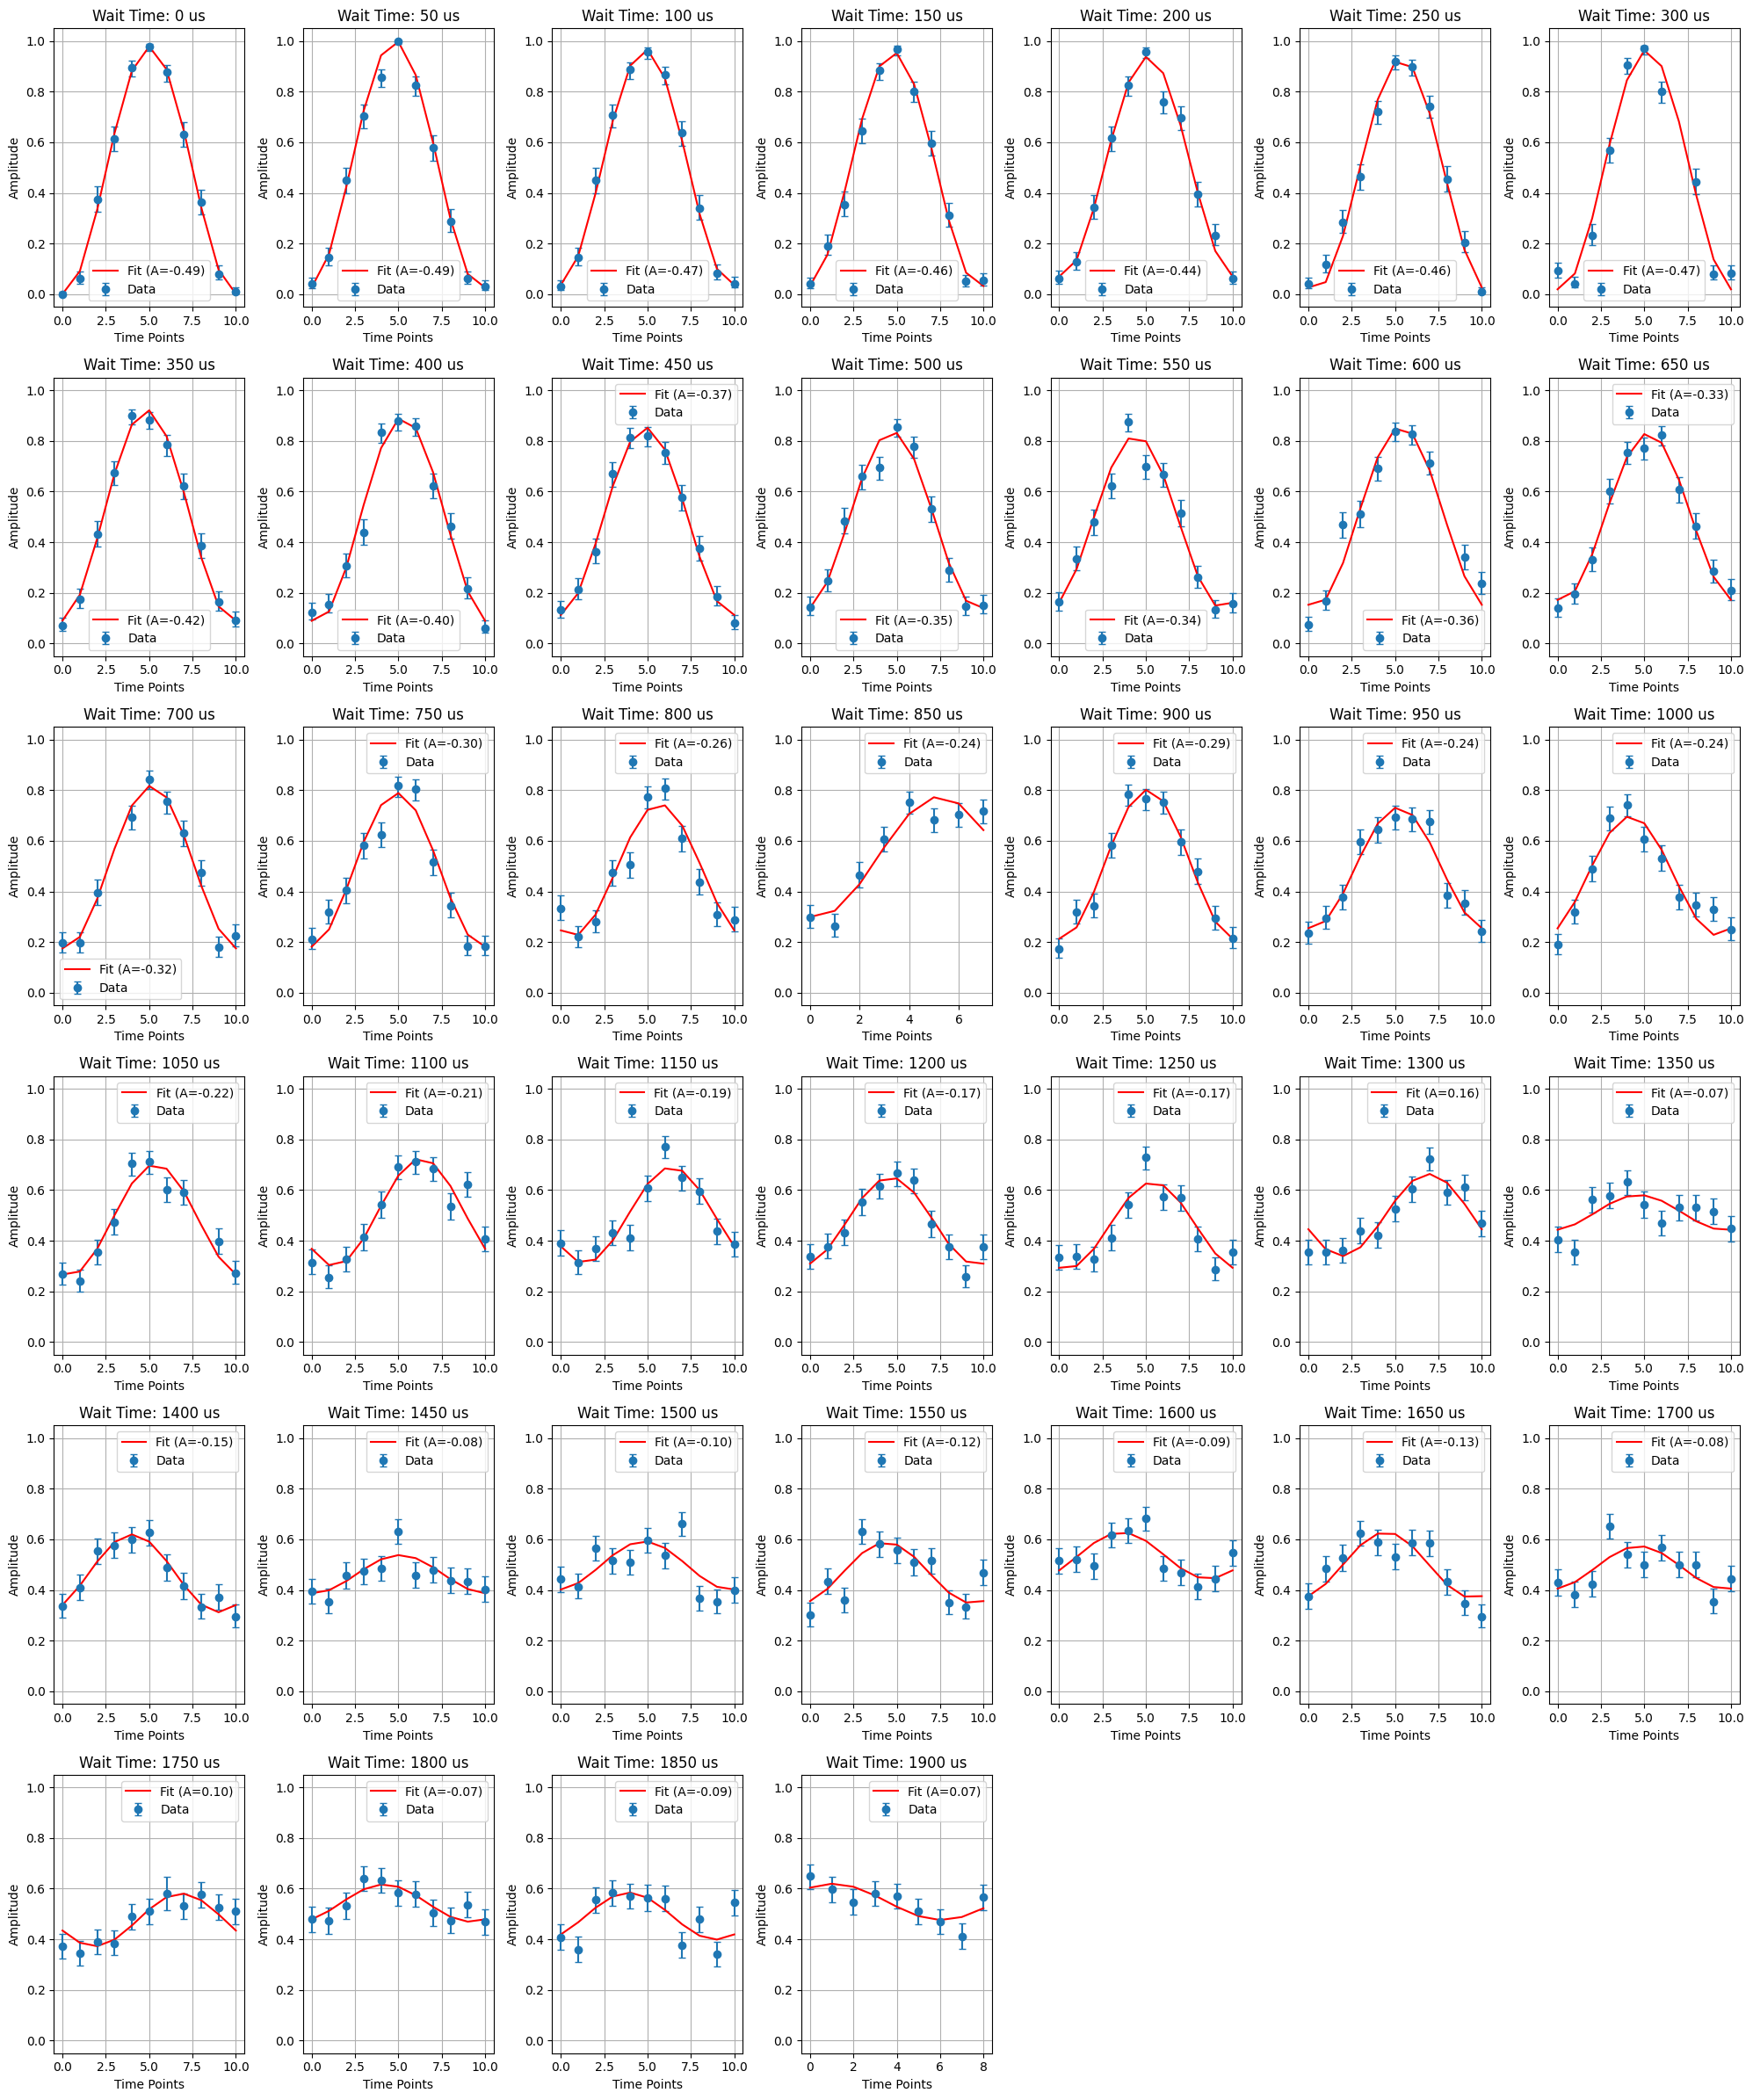


Fitted Results (Lists):
Wait Time: 0 us
  Params (A, phi, offset) = -0.489, -0.010, 0.490
  Amplitude (2*|A|) = 0.978 ± 0.013
  Phase = -0.010 ± 0.036
Wait Time: 50 us
  Params (A, phi, offset) = -0.490, 0.136, 0.512
  Amplitude (2*|A|) = 0.980 ± 0.013
  Phase = 0.136 ± 0.038
Wait Time: 100 us
  Params (A, phi, offset) = -0.467, 0.091, 0.502
  Amplitude (2*|A|) = 0.934 ± 0.021
  Phase = 0.091 ± 0.040
Wait Time: 150 us
  Params (A, phi, offset) = -0.464, 0.130, 0.493
  Amplitude (2*|A|) = 0.928 ± 0.020
  Phase = 0.130 ± 0.040
Wait Time: 200 us
  Params (A, phi, offset) = -0.435, -0.072, 0.504
  Amplitude (2*|A|) = 0.870 ± 0.023
  Phase = -0.072 ± 0.046
Wait Time: 250 us
  Params (A, phi, offset) = -0.459, -0.239, 0.472
  Amplitude (2*|A|) = 0.918 ± 0.022
  Phase = -0.239 ± 0.042
Wait Time: 300 us
  Params (A, phi, offset) = -0.474, -0.100, 0.491
  Amplitude (2*|A|) = 0.949 ± 0.021
  Phase = -0.100 ± 0.039
Wait Time: 350 us
  Params (A, phi, offset) = -0.417, 0.094, 0.506
  Amplitude (2

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Fixed frequency: 2π
def sine_function(t, A, phi, offset):
    return A * np.cos(2 * np.pi/10 * t + phi) + offset

def fit_sine_curve(ket_data, lower_error, upper_error):
    if len(ket_data) == 5:
        t = 2*np.arange(len(ket_data))
    else:
        t = np.arange(len(ket_data))
    valid_indices = ~np.isnan(ket_data) & ~np.isnan(lower_error) & ~np.isnan(upper_error)
    t_valid = t[valid_indices]
    ket_data_valid = np.array(ket_data)[valid_indices]
    lower_error_valid = np.array(lower_error)[valid_indices]
    upper_error_valid = np.array(upper_error)[valid_indices]

    sigma = (upper_error_valid + lower_error_valid) / 2.0
    if np.any(sigma <= 0):
        nonzero = sigma[sigma > 0]
        replacement = np.min(nonzero) if len(nonzero) > 0 else 1.0
        sigma[sigma <= 0] = replacement

    initial_guess = [
        (np.max(ket_data_valid) - np.min(ket_data_valid))/2,
        0,
        np.mean(ket_data_valid)
    ]
    try:
        params, covariance = curve_fit(
            sine_function,
            t_valid,
            ket_data_valid,
            p0=initial_guess,
            sigma=sigma,
            absolute_sigma=True, maxfev=10000
        )
        if covariance is not None:
            errors = np.sqrt(np.diag(covariance))
            errors = [err if np.isfinite(err) else None for err in errors]
        else:
            errors = [None] * len(params)

        return params, errors
    except RuntimeError:
        return None, None

def fit_all_wait_times_to_sine_in_lists(wait_time_list,
                                        ket_data_list,
                                        lower_error_list,
                                        upper_error_list):
    fit_wait_times_list = []
    fit_params_list = []
    fit_amplitudes_list = []
    fit_amplitude_errors_list = []
    fit_phases_list = []
    fit_phase_errors_list = []
    
    for i in range(len(wait_time_list)):
        wt = wait_time_list[i]
        kd = ket_data_list[i]
        le = lower_error_list[i]
        ue = upper_error_list[i]
        
        if len(kd) > 4:
            params, errors = fit_sine_curve(kd, le, ue)
            if params is not None and errors is not None and errors[0] is not None:
                A, phi, offset = params
                amplitude = 2.0 * abs(A)
                amplitude_error = 2.0 * errors[0] if errors[0] is not None else None
                phase_error = errors[1]

                fit_wait_times_list.append(wt)
                fit_params_list.append(params)
                fit_amplitudes_list.append(amplitude)
                fit_amplitude_errors_list.append(amplitude_error)
                fit_phases_list.append(phi)
                fit_phase_errors_list.append(phase_error)
        else:
            fit_wait_times_list.append(wt)
            fit_params_list.append([None, None, None])
            fit_amplitudes_list.append(None)
            fit_amplitude_errors_list.append(None)
            fit_phases_list.append(None)
            fit_phase_errors_list.append(None)
    return (
        fit_wait_times_list,
        fit_params_list,
        fit_amplitudes_list,
        fit_amplitude_errors_list,
        fit_phases_list,
        fit_phase_errors_list
    )

def plot_sine_fits_in_lists(wait_time_list,
                            ket_data_list,
                            lower_error_list,
                            upper_error_list,
                            fit_wait_times_list,
                            fit_params_list):
    num_plots = len(wait_time_list)
    num_columns = 7
    num_rows = (num_plots + num_columns - 1) // num_columns
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 4 * num_rows))
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
    
    for i in range(num_plots):
        wt = wait_time_list[i]
        kd = ket_data_list[i]
        le = lower_error_list[i]
        ue = upper_error_list[i]
        
        t = np.arange(len(kd))
        ax = axes[i]
        ax.errorbar(
            t,
            kd,
            yerr=[abs(le), abs(ue)],
            fmt='o',
            label='Data',
            capsize=3
        )
        
        if wt in fit_wait_times_list:
            j = fit_wait_times_list.index(wt)
            A, phi, offset = fit_params_list[i]
            if A is not None:
                fit_curve = sine_function(t, A, phi, offset)
                ax.plot(t, fit_curve, color='red', label=f'Fit (A={A:.2f})')

        ax.set_title(f'Wait Time: {wt} us')
        ax.set_xlabel('Time Points')
        ax.set_ylim(-0.05, 1.05)
        ax.set_ylabel('Amplitude')
        ax.grid()
        ax.legend()
    
    for i in range(num_plots, len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.savefig('laser_noise_phase_scans.svg')
    plt.show()

(
    fit_wait_times_list,
    fit_params_list,
    fit_amplitudes_list,
    fit_amplitude_errors_list,
    fit_phases_list,
    fit_phase_errors_list
) = fit_all_wait_times_to_sine_in_lists(
    wait_time_list,
    ket_data_list,
    lower_error_list,
    upper_error_list
)

plot_sine_fits_in_lists(
    wait_time_list,
    ket_data_list,
    lower_error_list,
    upper_error_list,
    fit_wait_times_list,
    fit_params_list
)

print("\nFitted Results (Lists):")
for i, wt in enumerate(fit_wait_times_list):
    A, phi, offset = fit_params_list[i]
    amp = fit_amplitudes_list[i]
    amp_err = fit_amplitude_errors_list[i]
    phase = fit_phases_list[i]
    phase_err = fit_phase_errors_list[i]
    print(f"Wait Time: {wt} us")
    print(f"  Params (A, phi, offset) = {A:.3f}, {phi:.3f}, {offset:.3f}")
    print(f"  Amplitude (2*|A|) = {amp:.3f} ± {amp_err:.3f}")
    print(f"  Phase = {phase:.3f} ± {phase_err:.3f}")


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import fsolve

# Fixed frequency: 2π
def sine_function(t, A, phi, offset):
    return A * np.cos(2 * np.pi/10 * t + phi) + offset

def combined_decay(t, A, T2_G, T2_L):
    gaussian_decay = np.exp(-(t / T2_G)**2)
    lorentzian_decay = np.exp(-t / T2_L)
    return A * gaussian_decay * lorentzian_decay

def fit_sine_curve(ket_data, lower_error, upper_error):
    if len(ket_data) == 5:
        t = 2*np.arange(len(ket_data))
    else:
        t = np.arange(len(ket_data))
    valid_indices = ~np.isnan(ket_data) & ~np.isnan(lower_error) & ~np.isnan(upper_error)
    t_valid = t[valid_indices]
    ket_data_valid = np.array(ket_data)[valid_indices]
    lower_error_valid = np.array(lower_error)[valid_indices]
    upper_error_valid = np.array(upper_error)[valid_indices]

    sigma = (upper_error_valid + lower_error_valid) / 2.0
    if np.any(sigma <= 0):
        nonzero = sigma[sigma > 0]
        replacement = np.min(nonzero) if len(nonzero) > 0 else 1.0
        sigma[sigma <= 0] = replacement

    initial_guess = [
        (np.max(ket_data_valid) - np.min(ket_data_valid))/2,
        0,
        np.mean(ket_data_valid)
    ]
    try:
        params, covariance = curve_fit(
            sine_function,
            t_valid,
            ket_data_valid,
            p0=initial_guess,
            sigma=sigma,
            absolute_sigma=True, maxfev=10000
        )
        if covariance is not None:
            errors = np.sqrt(np.diag(covariance))
            errors = [err if np.isfinite(err) else None for err in errors]
        else:
            errors = [None] * len(params)

        return params, errors
    except RuntimeError:
        return None, None

def fit_amplitude_decay(wait_times, amplitudes, errors):
    initial_guess = [
        float(np.max(amplitudes)),
        float(np.mean(wait_times)),
        float(np.mean(wait_times))
    ]
    try:
        params, pcov = curve_fit(
            combined_decay,
            wait_times,
            amplitudes,
            p0=initial_guess,
            sigma=errors,
            absolute_sigma=True,
            maxfev=10000
        )
        A, T2_G, T2_L = params
        return A, T2_G, T2_L, pcov
        # return params, pcov
    except RuntimeError:
        return None, None

def calculate_coherence_time(T2_G, T2_L):
    def decay_eq(t):
        return np.exp(-(t / T2_G)**2 - t / T2_L) - 1 / np.e
    t_coherence = fsolve(decay_eq, T2_G)
    return t_coherence[0]

def compute_partial_derivatives(T2_G, T2_L, t_eff):
    t = t_eff
    dF_dt = (2 * t) / T2_G**2 + 1 / T2_L
    dF_dT2_G = -2 * t**2 / T2_G**3
    dF_dT2_L = -t / T2_L**2
    dt_dT2_G = -dF_dT2_G / dF_dt
    dt_dT2_L = -dF_dT2_L / dF_dt
    return dt_dT2_G, dt_dT2_L

(
    fit_wait_times_list,
    fit_params_list,
    fit_amplitudes_list,
    fit_amplitude_errors_list,
    fit_phases_list,
    fit_phase_errors_list
) = fit_all_wait_times_to_sine_in_lists(
    wait_time_list,
    ket_data_list,
    lower_error_list,
    upper_error_list
)

A, T2_G, T2_L, pcov = fit_amplitude_decay(
    np.array(fit_wait_times_list),
    np.array(fit_amplitudes_list),
    np.array(fit_amplitude_errors_list)
)

if all(param is not None for param in [A, T2_G, T2_L, pcov]):
    sigma_A = np.sqrt(pcov[0, 0])
    sigma_T2_G = np.sqrt(pcov[1, 1])
    sigma_T2_L = np.sqrt(pcov[2, 2])
    cov_T2_G_T2_L = pcov[1, 2]
    print(f"Fitted Coherence Times:")
    print(f"A (Amplitude) = {A} ± {sigma_A}")
    print(f"T2_G (Gaussian) = {T2_G} ± {sigma_T2_G}")
    print(f"T2_L (Lorentzian) = {T2_L} ± {sigma_T2_L}")
    T2_eff = calculate_coherence_time(T2_G, T2_L)
    dt_dT2_G, dt_dT2_L = compute_partial_derivatives(T2_G, T2_L, T2_eff)
    sigma_T2_eff_squared = (
        (dt_dT2_G**2) * sigma_T2_G**2 +
        (dt_dT2_L**2) * sigma_T2_L**2 +
        2 * dt_dT2_G * dt_dT2_L * cov_T2_G_T2_L
    )
    sigma_T2_eff = np.sqrt(sigma_T2_eff_squared)
    print(f"Effective T2 Time: {T2_eff} ± {sigma_T2_eff}")
else:
    print("Fit failed or not enough data.")


Fitted Coherence Times:
A (Amplitude) = 0.9890404911169663 ± 0.00910289210567453
T2_G (Gaussian) = 1521.1210128727998 ± 77.94886345591927
T2_L (Lorentzian) = 3038.1329363025798 ± 471.4214489512237
Effective T2 Time: 1187.2658902112878 ± 19.025276869698065


In [26]:
def compute_T2(T_G, T_L):
    a = 1 / T_G**2
    b = 1 / T_L
    sqrt_term = np.sqrt(b**2 + 4 * a)
    T2 = (-b + sqrt_term) / (2 * a)
    return T2

# Nominal values
T_G = 1521.1210128727998
T_L = 3038.1329363025798
sigma_TG = 77.94886345591927
sigma_TL = 471.4214489512237

# Numerical partial derivatives
delta = 1e-3
dT2_dTG = (compute_T2(T_G + delta, T_L) - compute_T2(T_G - delta, T_L)) / (2 * delta)
dT2_dTL = (compute_T2(T_G, T_L + delta) - compute_T2(T_G, T_L - delta)) / (2 * delta)

# Final uncertainty
sigma_T2 = np.sqrt((dT2_dTG * sigma_TG)**2 + (dT2_dTL * sigma_TL)**2)
print(sigma_T2)

64.2150306134752


In [47]:
import numpy as np

# Given parameters
T_G = 1521.1210128727998e-6
T_L = 3038.1329363025798e-6
sigma_TG = 77.94886345591927e-6
sigma_TL = 471.4214489512237e-6

# Functions for Gamma_L and Gamma_G
def Gamma_L(T_L):
    return 2 / T_L

def Gamma_G(T_G):
    return (2 * np.sqrt(2 * np.log(2))) / T_G

# Voigt FWHM formula
def FWHM_V(T_L, T_G):
    gamma_L = Gamma_L(T_L)
    gamma_G = Gamma_G(T_G)
    return 0.5346 * gamma_L + np.sqrt(0.2166 * gamma_L**2 + gamma_G**2)

# Numerical partial derivatives using central difference
delta = 1e-9
dF_dTL = (FWHM_V(T_L + delta, T_G) - FWHM_V(T_L - delta, T_G)) / (2 * delta)
dF_dTG = (FWHM_V(T_L, T_G + delta) - FWHM_V(T_L, T_G - delta)) / (2 * delta)

# Error propagation
sigma_FWHM = np.sqrt((dF_dTL * sigma_TL)**2 + (dF_dTG * sigma_TG)**2)

# Result
print(f"FWHM_V = {FWHM_V(T_L, T_G):.4f} Hz ± {sigma_FWHM:.4f} Hz")


FWHM_V = 1930.0341 Hz ± 100.6544 Hz


Fitted Coherence Times:
A (Amplitude) = 0.9890404911169663 ± 0.00910289210567453
T2_G (Gaussian) = 1521.1210128727998 ± 77.94886345591927
T2_L (Lorentzian) = 3038.1329363025798 ± 471.4214489512237
Effective T2 Time: 1187.2658902112878 ± 19.025276869698065


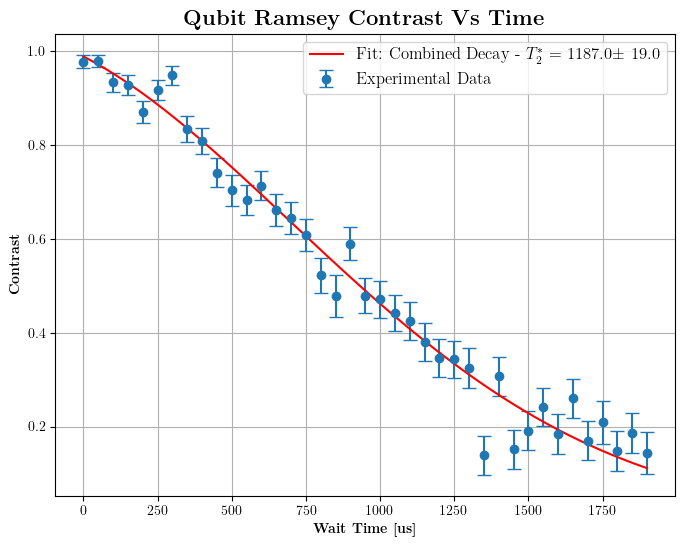

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Computer Modern']
rcParams['text.usetex'] = True

from scipy.optimize import curve_fit
from scipy.optimize import fsolve

# Fixed frequency: 2π
def sine_function(t, A, phi, offset):
    return A * np.cos(2 * np.pi/10 * t + phi) + offset

def combined_decay(t, A, T2_G, T2_L):
    gaussian_decay = np.exp(-(t / T2_G)**2)
    lorentzian_decay = np.exp(-t / T2_L)
    return A * gaussian_decay * lorentzian_decay

def fit_sine_curve(ket_data, lower_error, upper_error):
    if len(ket_data) == 5:
        t = 2*np.arange(len(ket_data))
    else:
        t = np.arange(len(ket_data))
    valid_indices = ~np.isnan(ket_data) & ~np.isnan(lower_error) & ~np.isnan(upper_error)
    t_valid = t[valid_indices]
    ket_data_valid = np.array(ket_data)[valid_indices]
    lower_error_valid = np.array(lower_error)[valid_indices]
    upper_error_valid = np.array(upper_error)[valid_indices]

    sigma = (upper_error_valid + lower_error_valid) / 2.0
    if np.any(sigma <= 0):
        nonzero = sigma[sigma > 0]
        replacement = np.min(nonzero) if len(nonzero) > 0 else 1.0
        sigma[sigma <= 0] = replacement

    initial_guess = [
        (np.max(ket_data_valid) - np.min(ket_data_valid))/2,
        0,
        np.mean(ket_data_valid)
    ]
    try:
        params, covariance = curve_fit(
            sine_function,
            t_valid,
            ket_data_valid,
            p0=initial_guess,
            sigma=sigma,
            absolute_sigma=True, maxfev=10000
        )
        if covariance is not None:
            errors = np.sqrt(np.diag(covariance))
            errors = [err if np.isfinite(err) else None for err in errors]
        else:
            errors = [None] * len(params)

        return params, errors    
    except RuntimeError:
        return None, None

def plot_fit(wait_times, amplitudes, errors, T2_G, T2_L, A, T2_eff, sigma_T2_eff):
    t_fit = np.linspace(min(wait_times), max(wait_times), 1000)
    amplitude_fit = combined_decay(t_fit, A, T2_G, T2_L)
    
    plt.figure(figsize=(8, 6))
    plt.errorbar(wait_times, amplitudes, yerr=errors, fmt='o', label='Experimental Data', capsize=5)
    plt.plot(t_fit, amplitude_fit, color='red', label=rf'Fit: Combined Decay - $T_2^*$ = {np.round(T2_eff)}± {np.round(sigma_T2_eff)}')
    
    plt.xlabel(r'$\textbf{Wait Time [us]}$')
    plt.ylabel(r'$\textbf{Contrast}$')
    plt.title(r'$\textbf{Qubit Ramsey Contrast Vs Time}$', fontsize = 16)
    plt.legend(fontsize = 12)
    plt.grid()
    plt.savefig('0_2_0_contrast_decay_for_laser_noise.svg')
    plt.show()

def fit_amplitude_decay(wait_times, amplitudes, errors):
    initial_guess = [
        float(np.max(amplitudes)),
        float(np.mean(wait_times)),
        float(np.mean(wait_times))
    ]
    try:
        params, pcov = curve_fit(
            combined_decay,
            wait_times,
            amplitudes,
            p0=initial_guess,
            sigma=errors,
            absolute_sigma=True,
            maxfev=10000
        )
        A, T2_G, T2_L = params
        return A, T2_G, T2_L, pcov
    except RuntimeError:
        return None, None

def calculate_coherence_time(T2_G, T2_L):
    def decay_eq(t):
        return np.exp(-(t / T2_G)**2 - t / T2_L) - 1 / np.e
    t_coherence = fsolve(decay_eq, T2_G)
    return t_coherence[0]

def compute_partial_derivatives(T2_G, T2_L, t_eff):
    t = t_eff
    dF_dt = (2 * t) / T2_G**2 + 1 / T2_L
    dF_dT2_G = -2 * t**2 / T2_G**3
    dF_dT2_L = -t / T2_L**2
    dt_dT2_G = -dF_dT2_G / dF_dt
    dt_dT2_L = -dF_dT2_L / dF_dt
    return dt_dT2_G, dt_dT2_L

(
    fit_wait_times_list,
    fit_params_list,
    fit_amplitudes_list,
    fit_amplitude_errors_list,
    fit_phases_list,
    fit_phase_errors_list
) = fit_all_wait_times_to_sine_in_lists(
    wait_time_list,
    ket_data_list,
    lower_error_list,
    upper_error_list
)

A, T2_G, T2_L, pcov = fit_amplitude_decay(
    np.array(fit_wait_times_list),
    np.array(fit_amplitudes_list),
    np.array(fit_amplitude_errors_list)
)

if all(param is not None for param in [A, T2_G, T2_L, pcov]):
    sigma_A = np.sqrt(pcov[0, 0])
    sigma_T2_G = np.sqrt(pcov[1, 1])
    sigma_T2_L = np.sqrt(pcov[2, 2])
    cov_T2_G_T2_L = pcov[1, 2]
    print(f"Fitted Coherence Times:")
    print(f"A (Amplitude) = {A} ± {sigma_A}")
    print(f"T2_G (Gaussian) = {T2_G} ± {sigma_T2_G}")
    print(f"T2_L (Lorentzian) = {T2_L} ± {sigma_T2_L}")
    T2_eff = calculate_coherence_time(T2_G, T2_L)
    dt_dT2_G, dt_dT2_L = compute_partial_derivatives(T2_G, T2_L, T2_eff)
    sigma_T2_eff_squared = (
        (dt_dT2_G**2) * sigma_T2_G**2 +
        (dt_dT2_L**2) * sigma_T2_L**2 +
        2 * dt_dT2_G * dt_dT2_L * cov_T2_G_T2_L
    )
    sigma_T2_eff = np.sqrt(sigma_T2_eff_squared)
    print(f"Effective T2 Time: {T2_eff} ± {sigma_T2_eff}")
    plot_fit(fit_wait_times_list, fit_amplitudes_list, fit_amplitude_errors_list, T2_G, T2_L, A, T2_eff, sigma_T2_eff)
else:
    print("Fit failed or not enough data.")


In [21]:
%matplotlib widget

147.9692129255322 52.38577324584998


C:\Users\Gaurav\AppData\Local\Temp\ipykernel_158468\844958353.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


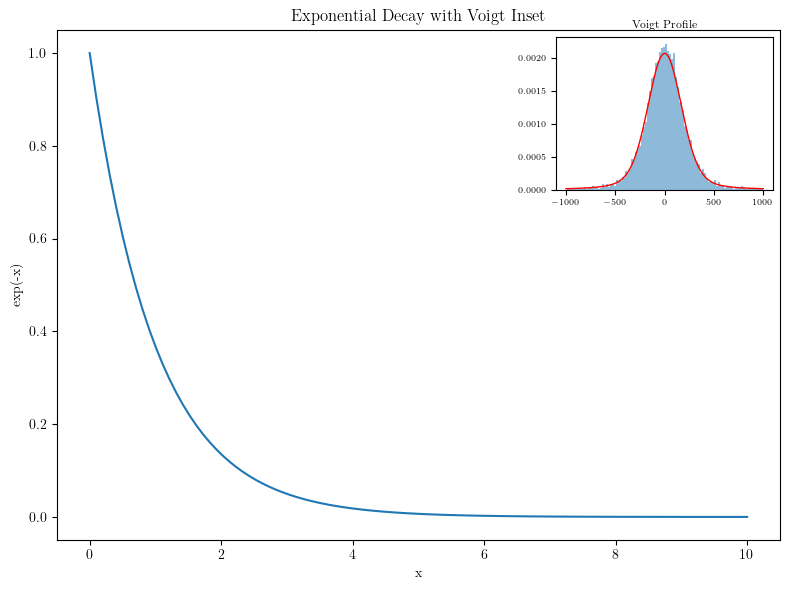

In [49]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import voigt_profile
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Voigt profile setup
T = 2*np.pi*1521.1210128727998e-6  # Gaussian width parameter
L = 2*np.pi*3038.1329363025798e-6  # Lorentzian width parameter
sigma = np.sqrt(2) / T
gamma = 1.0 / L
print(sigma, gamma)
def V(x):
    return voigt_profile(x, sigma, gamma)

x_min = -1000
x_max = 1000
res = 1000000
x_vals = np.linspace(x_min, x_max, res)
dx = x_vals[1] - x_vals[0]

V_vals = V(x_vals)
cdf = np.cumsum(V_vals) * dx
cdf /= cdf[-1]

def sample_voigt(n_samples):
    u = np.random.rand(n_samples)
    samples = np.interp(u, cdf, x_vals)
    return samples

n_samples = 10000
samples = sample_voigt(n_samples)

# Main plot: Exponential decay
fig, ax = plt.subplots(figsize=(8, 6))
x_main = np.linspace(0, 10, 100)
y_main = np.exp(-x_main)
ax.plot(x_main, y_main, label="Exponential Decay")
ax.set_title("Exponential Decay with Voigt Inset")
ax.set_xlabel("x")
ax.set_ylabel("exp(-x)")

# Inset plot: Voigt profile and histogram
inset_ax = inset_axes(ax, width="30%", height="30%", loc="upper right")
inset_ax.hist(samples, bins=100, density=True, alpha=0.5, label='Samples')
inset_ax.plot(x_vals[::1000], V_vals[::1000], 'r-', lw=1, label='Voigt')
inset_ax.set_title("Voigt Profile", fontsize=8)
inset_ax.tick_params(labelsize=6)

plt.tight_layout()
plt.show()


C:\Users\Gaurav\AppData\Local\Temp\ipykernel_158468\3820776887.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


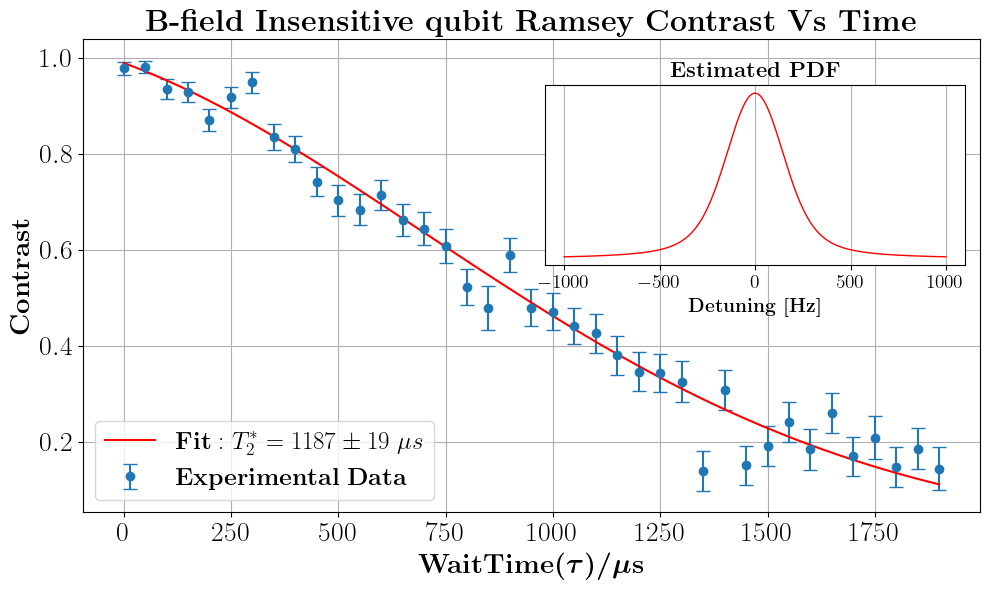

In [39]:
def plot_fit(wait_times, amplitudes, errors, T2_G, T2_L, A, T2_eff, sigma_T2_eff):

    import matplotlib.pyplot as plt
    import numpy as np
    from scipy.special import voigt_profile
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    
    t_fit = np.linspace(min(wait_times), max(wait_times), 1000)
    amplitude_fit = combined_decay(t_fit, A, T2_G, T2_L)
    
    # Voigt profile setup
    T = 2*np.pi*1916.0e-6  # Gaussian width parameter
    L = 2*np.pi*2054.0e-6  # Lorentzian width parameter
    sigma = np.sqrt(2) / T
    gamma = 1.0 / L
    
    def V(x):
        return voigt_profile(x, sigma, gamma)
    
    x_min = -1000
    x_max = 1000
    res = 1000000
    x_vals = np.linspace(x_min, x_max, res)
    dx = x_vals[1] - x_vals[0]
    
    V_vals = V(x_vals)
    cdf = np.cumsum(V_vals) * dx
    cdf /= cdf[-1]
    
    def sample_voigt(n_samples):
        u = np.random.rand(n_samples)
        samples = np.interp(u, cdf, x_vals)
        return samples
    
    n_samples = 10000
    samples = sample_voigt(n_samples)
    
    # Main plot: Exponential decay
    fig, ax = plt.subplots(figsize=(10, 6))
    # ax.errorbar(wait_times, amplitudes, yerr=errors, fmt='o', label='Experimental Data', capsize=5)
    # ax.plot(t_fit, amplitude_fit, color='red', label=rf'Fit: $T_2^*$ = {np.round(T2_eff)}± {np.round(sigma_T2_eff)}')

    ax.errorbar(wait_times, amplitudes, yerr=errors, fmt='o',
                label=r'$\mathbf{Experimental\ Data}$', capsize=5)
    
    ax.plot(t_fit, amplitude_fit, color='red',
            label=rf'$\mathbf{{Fit:\ }} T_2^* = {int(T2_eff)} \pm {int(sigma_T2_eff)}\ \mu s$')

    
    ax.set_xlabel(r'\boldmath$\mathbf{Wait Time (\tau) /\mu s}$', fontsize = 20)
    ax.set_ylabel(r'\textbf{Contrast}', fontsize= 20)
    ax.set_title(r'\textbf{B-field Insensitive qubit Ramsey Contrast Vs Time}', fontsize = 22)
    # ax.set_xlabel("x")
    # ax.set_ylabel("exp(-x)")
    
    # Inset plot: Voigt profile and histogram
    # inset_ax = inset_axes(ax, width="50%", height="50%", loc="upper right", borderpad=2.5)
    inset_ax = fig.add_axes([0.55, 0.55, 0.420, 0.3])  # [left, bottom, width, height] in figure coordinates

    # inset_ax.hist(samples, bins=100, density=True, alpha=0.5, label='Samples')
    inset_ax.plot(x_vals[::750], V_vals[::750], 'r-', lw=1)
    inset_ax.set_title(r'$\textbf{Estimated PDF}$', fontsize=16)
    inset_ax.set_yticks([])
    
    inset_ax.set_xlabel(r'$\textbf{Detuning [Hz]}$',  fontsize=14)
    inset_ax.tick_params(labelsize=14)
    inset_ax.grid()
    ax.legend(loc = "lower left", fontsize = 18)
    ax.grid()
    ax.tick_params(labelsize = 20)
    plt.tight_layout()
    plt.savefig('Laser_noise_plot.svg')
    plt.show()



plot_fit(fit_wait_times_list, fit_amplitudes_list, fit_amplitude_errors_list, T2_G, T2_L, A, T2_eff, sigma_T2_eff)

407.84700840837303


C:\Users\Gaurav\AppData\Local\Temp\ipykernel_158468\1778713996.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


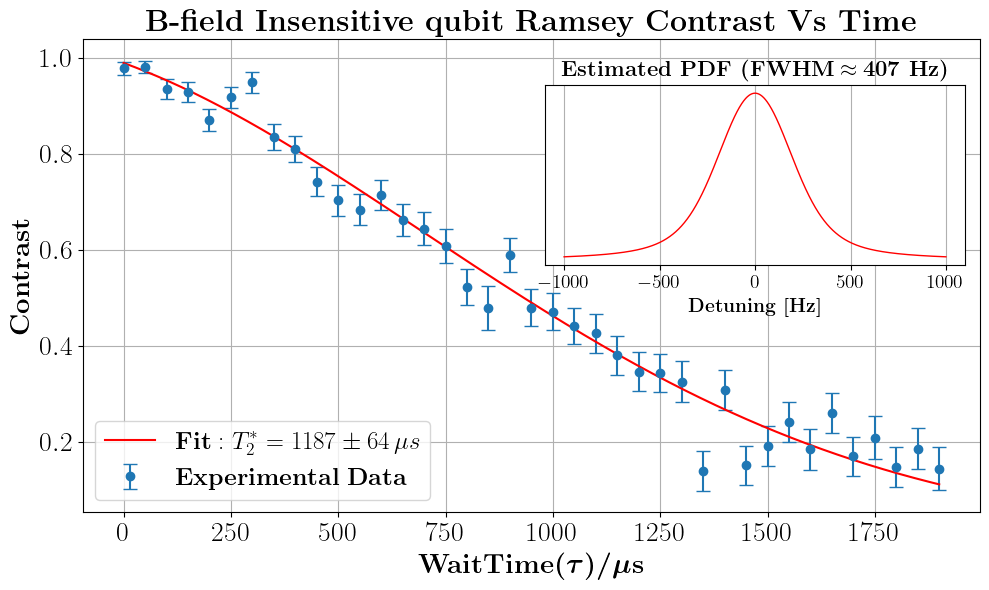

In [86]:
def plot_fit(wait_times, amplitudes, errors, T2_G, T2_L, A, T2_eff, sigma_T2_eff):

    import matplotlib.pyplot as plt
    import numpy as np
    from scipy.special import voigt_profile
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    
    t_fit = np.linspace(min(wait_times), max(wait_times), 1000)
    amplitude_fit = combined_decay(t_fit, A, T2_G, T2_L)
    
    # Voigt profile setup
    T = 2*np.pi*1521.1210128727998e-6  # Gaussian width parameter
    L = np.pi*3038.1329363025798e-6  # Lorentzian width parameter
    sigma = np.sqrt(2) / T
    gamma = 1.0 / L
    
    def V(x):
        return voigt_profile(x, sigma, gamma)
    
    x_min = -1000
    x_max = 1000
    res = 1000000
    x_vals = np.linspace(x_min, x_max, res)
    dx = x_vals[1] - x_vals[0]
    
    V_vals = V(x_vals)
    cdf = np.cumsum(V_vals) * dx
    cdf /= cdf[-1]
    
    def sample_voigt(n_samples):
        u = np.random.rand(n_samples)
        samples = np.interp(u, cdf, x_vals)
        return samples
    
    n_samples = 10000
    samples = sample_voigt(n_samples)

    # Compute Voigt FWHM
    fwhm_G = 2.35482 * sigma
    fwhm_L =  gamma
    fwhm_V = 0.5346 * fwhm_L + np.sqrt(0.2166 * fwhm_L**2 + fwhm_G**2)
    print(fwhm_V)
    # Main plot: Exponential decay
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.errorbar(wait_times, amplitudes, yerr=errors, fmt='o',
                label=r'$\mathbf{Experimental\ Data}$', capsize=5)
    
    ax.plot(t_fit, amplitude_fit, color='red',
            label=rf'$\mathbf{{Fit:\ }} T_2^* = {int(T2_eff)} \pm 64\, \mu s$')
    
    ax.set_xlabel(r'\boldmath$\mathbf{Wait Time (\tau) /\mu s}$', fontsize = 20)
    ax.set_ylabel(r'\textbf{Contrast}', fontsize= 20)
    ax.set_title(r'\textbf{B-field Insensitive qubit Ramsey Contrast Vs Time}', fontsize = 22)
    
    # Inset plot: Voigt profile
    inset_ax = fig.add_axes([0.55, 0.55, 0.420, 0.3])
    inset_ax.plot(x_vals[::750], V_vals[::750], 'r-', lw=1,
                  label=r'\textbf{FWHM} $\approx$ ' + f'{fwhm_V:.1f} Hz')
    inset_ax.set_title(r'$\textbf{Estimated PDF (FWHM} \approx \textbf{407 Hz)}$', fontsize=16)
    inset_ax.set_yticks([])
    inset_ax.set_xlabel(r'$\textbf{Detuning [Hz]}$',  fontsize=14)
    inset_ax.tick_params(labelsize=14)
    inset_ax.grid()
    # inset_ax.legend(fontsize=14, loc='upper right')

    ax.legend(loc = "lower left", fontsize = 18)
    ax.grid()
    ax.tick_params(labelsize = 20)
    plt.tight_layout()
    plt.savefig('Laser_noise_plot.svg')
    plt.show()
plot_fit(fit_wait_times_list, fit_amplitudes_list, fit_amplitude_errors_list, T2_G, T2_L, A, T2_eff, sigma_T2_eff)

In [71]:
import numpy as np

def calculate_voigt_fwhm(T_G_sec, T_L_sec):
    """
    Calculates the FWHM of a Voigt profile from time-domain decay constants.

    This function first converts the Gaussian and Lorentzian time constants
    (T_G and T_L) into their respective frequency-domain FWHMs (f_G and f_L).
    It then uses the Olivero & Longbothum approximation to calculate the
    FWHM of the resulting Voigt profile.

    Args:
        T_G_sec (float): The Gaussian decay constant in seconds.
                         e.g., from a decay term like exp(-t^2 / T_G^2).
        T_L_sec (float): The Lorentzian decay constant in seconds.
                         e.g., from a decay term like exp(-t / T_L).

    Returns:
        float: The Full Width at Half Maximum (FWHM) of the Voigt profile in Hertz (Hz).
    """
    if T_G_sec <= 0 or T_L_sec <= 0:
        raise ValueError("Time constants T_G and T_L must be positive.")

    # 1. Calculate the FWHM of the Lorentzian part in Hz
    # f_L = 1 / (pi * T_L)
    f_L = 1 / (np.pi * T_L_sec)

    # 2. Calculate the FWHM of the Gaussian part in Hz
    # The standard deviation in frequency is sigma_f = 1 / (sqrt(2) * pi * T_G)
    # The FWHM for a Gaussian is f_G = 2 * sqrt(2 * ln(2)) * sigma_f
    # This simplifies to f_G = (2 * sqrt(ln(2))) / (pi * T_G)
    f_G = (2 * np.sqrt(2 * np.log(2))) / (np.sqrt(2) * np.pi * T_G_sec) # Simplified form

    # 3. Use the Olivero & Longbothum approximation for the Voigt FWHM
    # f_V ≈ 0.5346 * f_L + sqrt(0.2166 * f_L^2 + f_G^2)
    f_V = 0.5346 * f_L + np.sqrt(0.2166 * f_L**2 + f_G**2)

    return f_V

# --- Example Usage ---
# Using the values from your previous question:
# T_G = 1500 µs = 1500e-6 s
# T_L = 3000 µs = 3000e-6 s

T_G = 1521.1210128727998e-6
T_L = 3038.1329363025798e-6

# Calculate the FWHM
voigt_fwhm_hz = calculate_voigt_fwhm(T_G, T_L)

print(f"Given:")
print(f"  T_G = {T_G * 1e6:.0f} µs")
print(f"  T_L = {T_L * 1e6:.0f} µs")
print("-" * 25)
print(f"The FWHM of the Voigt profile is: {voigt_fwhm_hz:.2f} Hz")

Given:
  T_G = 1521 µs
  T_L = 3038 µs
-------------------------
The FWHM of the Voigt profile is: 407.85 Hz


In [69]:
import numpy as np

def voigt_width(Tg, Tl):
    sG = 1 / (np.sqrt(2) * np.pi * Tg)
    dG = 2 * np.sqrt(np.log(2)) / (np.pi * Tg)
    dL = 1 / (np.pi * Tl)
    dV = 0.5346 * dL + np.sqrt(0.2166 * dL**2 + dG**2)
    return sG, dG, dL, dV


Tg = 1.521e-3      # 1500 µs
Tl = 3.038e-3      # 3000 µs
sigma_G, FWHM_G, FWHM_L, FWHM_V = voigt_width(Tg, Tl)
print(sigma_G, FWHM_G, FWHM_L, FWHM_V)


147.98098556165453 348.4685910840195 104.77613106773887 407.877216545483


In [73]:
import numpy as np

def widths(Tg, Tl):
    ln2 = np.log(2)
    sG = 1 / (np.sqrt(2) * np.pi * Tg)
    dG = 2 * np.sqrt(ln2) / (np.pi * Tg)
    dL = 1 / (np.pi * Tl)
    dV = 0.5346 * dL + np.sqrt(0.2166 * dL ** 2 + dG ** 2)
    return sG, dG, dL, dV

def voigt_fwhm_uncertainty(Tg, Tl, dTg, dTl):
    ln2 = np.log(2)
    dG = 2 * np.sqrt(ln2) / (np.pi * Tg)
    dL = 1 / (np.pi * Tl)
    B = np.sqrt(0.2166 * dL ** 2 + dG ** 2)
    dV_dG = dG / B
    dV_dL = 0.5346 + 0.2166 * dL / B
    var = (dV_dG * dG / Tg * dTg) ** 2 + (dV_dL * dL / Tl * dTl) ** 2
    return np.sqrt(var)


Tg = 1.521e-3      # 1500 µs
Tl = 3.038e-3      # 3000 µs
dTg = 77.0e-6
dTl = 471.0e-6
print(widths(Tg, Tl))
print(voigt_fwhm_uncertainty(Tg, Tl, dTg, dTl))


(147.98098556165453, 348.4685910840195, 104.77613106773887, 407.877216545483)
19.998466761683304


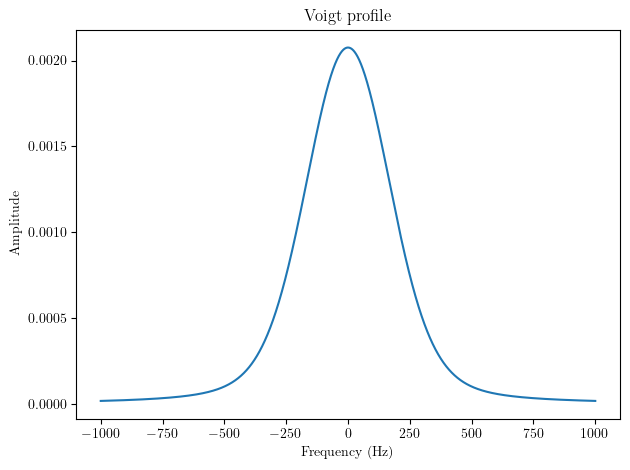

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import wofz

Tg = 1.521e-3      # 1500 µs
Tl = 3.038e-3      # 3000 µs
sigma = 1 / (np.sqrt(2) * np.pi * Tg)
gamma = 1 / (2 * np.pi * Tl)
f = np.linspace(-1000, 1000, 4001)
z = (f + 1j * gamma) / (sigma * np.sqrt(2))
V = np.real(wofz(z)) / (sigma * np.sqrt(2 * np.pi))

plt.figure()
plt.plot(f, V)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Voigt profile")
plt.tight_layout()
plt.show()
